# Visualize nucleotide importance score predictions and experimental outcomes of a second mutagenesis pair
Required inputs: same as `enhancer_mutagenesis.ipynb`.

Outputs:
* `swap_combined_barplot_pair_3.svg`: The observed effect of scrambling various parts of the strong enhancer.
* `representativePair{StrongEnhancer,Inactive}_pair_3.svg`: Cartoon diagrams of the strong enhancer and inactive sequence.
* `saliencyActual{StrongEnhancer,Inactive}_pair_3.svg`: Saliency maps for the two sequences.
* `inactiveSwapsCombinedBarplot_pair_3.svg` and `inactiveSwapsCartoons_pair_3.svg`: The observed effect of swapping various parts of the strong enhancer into the inactive sequence and associated cartoons.
* `strongEnhancerSlide_RORB_3.svg`: The observed effect of sliding the RORB motif along the strong enhancer.
* `strongEnhancerSlideImportance_RORB_Pair_3.svg`: The predicted importance of the RORB motif when it is slid along the strong enhancer.

In [1]:
import os
import sys
import re
import string
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import logomaker

from src.mpra_tools import deeplift_utils, loaders, predicted_occupancy, plot_utils
from src.selene_files.enhancer_resnet_regression import EnhancerResnet

data_dir = "Data"
figures_dir = "Figures"
plot_utils.set_manuscript_params()

/ref/bclab/software/dlyon/spack/opt/spack/linux-rocky8-x86_64/gcc-8.5.0/miniconda3-4.10.3-2vnv4wet2ju7hlsej5cgneo6trlw7lly/envs/active-learning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Functions copied from `enhancer_mutagenesis.ipynb`.

In [2]:
def _decode_block(x):
    begin, end = x.split("-")
    return (int(begin), int(end))

def decode_blocks(coords):
    return [_decode_block(x) for x in coords]

# Determine if a pair of coordinates are adjacent, and if so, merge them
def join_coords(coords):
    new_coords = []
    begin = coords[0][0]
    for i in range(len(coords) - 1):
        current = coords[i + 1]
        previous = coords[i]
        # End of a block!
        if previous[1] != current[0]:
            new_coords.append((begin, previous[1]))
            begin = current[0]
            
    # Check if we closed off the block
    last = coords[-1][1]
    if len(new_coords) == 0 or new_coords[-1][1] != coords[-1][1]:
        new_coords.append((begin, last))
    
    return new_coords

def coord_string(coords, site_map, offset, max_block_size=None):
    shift = coords[0] + offset
    if shift in site_map.keys():
        tf, strand = site_map[shift].split("_")
        result = tf.capitalize() + "_" + strand
    else:
        begin, end = coords
        if max_block_size and (end - begin > max_block_size):
            result = ""
        else:
            result = f"[{begin},{end})"
    
    return result

def decode(encoding, site_map):
    coords = re.compile("x(\d+\-\d+)").findall(encoding)
    decoded = decode_blocks(coords)
    if len(coords) > 1:
        decoded = join_coords(decoded)
    n = len(decoded)
    # Now turn each coordinate into a string
    decoded_str = [coord_string(i, site_map, offset=3) for i in decoded]
    decoded_str = ",".join(decoded_str)
    # Blocks longer than 20 bp don't get decoded
    if len(decoded_str) == 0:
        decoded_str = np.nan
    
    return pd.Series({
        "decoding": decoded_str,
        "n_blocks": n,
        "first_start": decoded[0][0] 
    })

def int_to_lowercase(i):
    return chr(i+97)

def int_to_uppercase(i):
    return chr(i+65)

def get_block_coords(block_str):
    splitter = list(map(int, block_str.split(",")))
    # Append the final position to make code easier
    splitter.append(164)
    block_letter_map = {}
    for i, start in enumerate(splitter[:-1]):
        block_id = int_to_uppercase(i)
        block_letter_map[block_id] = (start, splitter[i+1])
    
    return pd.Series(block_letter_map)

def decode_swapped_block(x, decoder):
    return decoder[x]

light_blue = (166/255, 206/255, 227/255)
dark_blue = (31/255, 120/255, 180/255)
light_green = (178/255, 223/255, 138/255)
dark_green = (51/255, 160/255, 44/255)

def assign_block_type(map, block_coord):
    if block_coord[0] in map.keys():
        return "TF"
    else:
        return "block"

def block_in_order(blocks):
    # Check if blocks are in alphabetal order
    n_blocks = len(blocks.strip(","))
    ordered_blocks = string.ascii_lowercase[:n_blocks]
    if blocks.strip(",").lower() == ordered_blocks:
        return True
    else:
        return False

def assign_block_color(block, block_coord, SE_TF_color=(31/255, 120/255, 180/255), SE_block_color=(166/255, 206/255, 227/255), IN_TE_color=(51/255, 160/255, 44/255), IN_block_color=(178/255, 223/255, 138/255)):
    if block.isupper() and assign_block_type(block_coord) == "TF":
        return SE_TF_color
    elif block.isupper() and assign_block_type(block_coord) == "block":
        return SE_block_color
    elif block.islower() and assign_block_type(block_coord) == "TF":
        return IN_TF_color
    elif block.islower() and assign_block_type(block_coord) == "block":
        return IN_block_color

def custom_sort_key(s):
    # A customized sorting function to sort swapped sequences
    # Rule 1: More uppercase letters should come last
    # Rule 2: For the same number of uppercase letters, use the specified letter-wise comparison
    n_uppercase = sum(1 for x in s if x.isupper())
    return (-n_uppercase, [(-ord(x.lower()), 1 if x.isupper() else 0) for x in s])

def sort_blocks(ss):
    sorted_ss = sorted(ss, key=custom_sort_key, reverse=True)
    return [sorted_ss[-1]] + sorted_ss[:-1]

In [3]:
## Load CNN model
L = 164
model = loaders.load_cnn(
    os.path.join("ModelFitting", "CNN_Reg", "best_model", "best_model.pth.tar"),
    model=EnhancerResnet(L),
    eval_mode=True,
)
blocks = loaders.load_data(
    os.path.join("Data", "Swaps", "blocks.txt"),
    index_col=None
)
swap_coords = loaders.load_data(
    os.path.join("Data", "Swaps", "swap_coords.txt"),
    index_col=None,
)
slide_coords = loaders.load_data(
    os.path.join("Data", "Swaps", "slide_coords.txt"),
    index_col=None,
)
activity_df = loaders.load_data(
    os.path.join(data_dir, "activity_summary_stats_and_metadata.txt")
)
swap_pair_mask = activity_df["label"].isin(
    pd.concat([swap_coords["label"], slide_coords["label"]])
)
activity_df = activity_df[swap_pair_mask]
sequences = activity_df.set_index("label")["sequence"].drop_duplicates()

ewms = predicted_occupancy.read_pwm_to_ewm(
    os.path.join("Data", "Downloaded", "eLifeMotifs.meme")
).rename(lambda x: x.split("_")[0])
mu = 9

/ref/bclab/software/dlyon/spack/opt/spack/linux-rocky8-x86_64/gcc-8.5.0/miniconda3-4.10.3-2vnv4wet2ju7hlsej5cgneo6trlw7lly/envs/active-learning/lib/python3.9/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


chr9-121694789-121694953_CPPE chr7-99397328-99397492_UPPE
{78: 'CRX_F', 129: 'RORB_R'}
{56: 'RORB_F', 78: 'CRX_F'}


,mean,std,count
decoding,,,
WT,4.022892,1.109304,11
"Crx_F,Rorb_R",1.131526,0.275989,3
"[0,20)",4.648025,0.252313,5
"[10,30)",4.665775,0.248946,5
"[20,40)",4.657025,0.208451,5
"[30,50)",4.512197,0.207067,5
"[40,60)",4.613273,0.176483,5
"[50,70)",4.662436,0.120280,5
"[55,75)",4.519804,0.410746,5


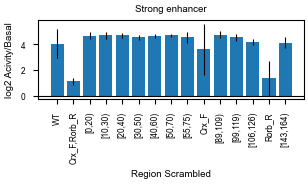

In [4]:
i = 3
strong_enhancer_id = blocks["strong_enhancer_label"][i]
inactive_id = blocks["inactive_label"][i]
block_starts = blocks["block_start_coords"][i]
strong_enhancer_wt_seq = sequences[strong_enhancer_id + "_WT"]
inactive_wt_seq = sequences[inactive_id + "_WT"]
print(strong_enhancer_id, inactive_id)
scramble_coords = swap_coords[
    (swap_coords["original_seq"] == strong_enhancer_id) &\
    swap_coords["blocks"].str.contains("x")
]
# Get a map of the occupied sites
strong_site_map = predicted_occupancy.get_occupied_sites_and_tfs(
    predicted_occupancy.total_landscape(strong_enhancer_wt_seq, ewms, mu)
)
print(strong_site_map)

# Get the inactive site map
inactive_site_map = predicted_occupancy.get_occupied_sites_and_tfs(
    predicted_occupancy.total_landscape(inactive_wt_seq, ewms, mu)
)
print(inactive_site_map)

# Put the label on the index to facilitate groupby
# Then decode the coordinates into a string
coords_decoded = scramble_coords.set_index("label")["blocks"].apply(decode, args=(strong_site_map,))
# Add in WT
coords_decoded.loc[strong_enhancer_id + "_WT"] = ["WT", np.inf, np.inf]
# Get the measurements
cleaned_labels = activity_df["label"].str.removesuffix("_v2").str.removesuffix("_v3")
pair_activity_df = activity_df[
    activity_df["label"].isin(coords_decoded.index)
].set_index("label")
# Now rename the index to the string decoding
pair_activity_df = pair_activity_df.rename(coords_decoded["decoding"])
# Finally, average across replicate measurements
scrambled_averaged = pair_activity_df.groupby("label")["expression_log2"].agg(["mean", "std", "count"])

# Define a sort order
sort_order = coords_decoded.dropna().set_index(
    "decoding").drop_duplicates().sort_values(
    ["n_blocks", "first_start"], ascending=[False, True]
).index
scrambled_averaged = scrambled_averaged.loc[sort_order]
display(scrambled_averaged)

fig, ax = plt.subplots(figsize=plot_utils.get_figsize(0.5, aspect=0.3))
ax.bar(
    np.arange(len(scrambled_averaged)),
    scrambled_averaged["mean"],
    yerr=scrambled_averaged["std"],
    tick_label=scrambled_averaged.index
)
ax.axhline(0, color="k")
ax.set_xlabel("Region Scrambled")
ax.set_ylabel("log2 Acivity/Basal")
ax.set_title("Strong enhancer")
plot_utils.rotate_ticks(ax.get_xticklabels(), 90)
plot_utils.save_fig(fig, os.path.join(figures_dir, f"swap_combined_barplot_pair_{i}"))

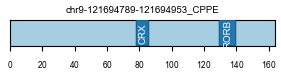

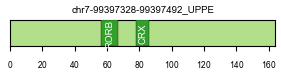

In [5]:
fig, ax = plot_utils.visualize_sequence(
    strong_enhancer_wt_seq,
    light_blue,
    ewms,
    mu,
    dark_blue,
    above_text=strong_enhancer_id,
)
plot_utils.save_fig(fig, os.path.join(figures_dir, f"representativePairStrongEnhancer_pair_{i}"))
fig, ax = plot_utils.visualize_sequence(
    inactive_wt_seq,
    light_green,
    ewms,
    mu,
    dark_green,
    above_text=inactive_id,
)
plot_utils.save_fig(fig, os.path.join(figures_dir, f"representativePairInactive_pair_{i}"))

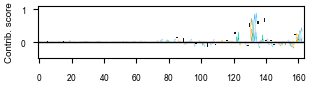

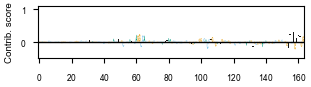

In [6]:
ylims = (-0.5055550932884216, 1.0973039865493774)

hypo, actual, pred = deeplift_utils.saliency_map(strong_enhancer_wt_seq, model)
fig, ax = plot_utils.plot_deeplift(actual)
# print(ax.get_ylim())
ax.set_ylim(ylims)
# ax.set_title(strong_enhancer_id, x=0.01, y=1, ha="left")
plot_utils.save_fig(fig, os.path.join(figures_dir, f"saliencyActualStrongEnhancer_pair_{i}"))

hypo, actual, pred = deeplift_utils.saliency_map(inactive_wt_seq, model)
fig, ax = plot_utils.plot_deeplift(actual)
# print(ax.get_ylim())
ax.set_ylim(ylims)
# ax.set_title(inactive_id, x=0.01, y=1, ha="left")
plot_utils.save_fig(fig, os.path.join(figures_dir, f"saliencyActualInactive_pair_{i}"))

In [7]:
block_coords = get_block_coords(block_starts)
n = len(block_coords)
print("Mapping from block letters to coordinates:")
display(block_coords)
ordered_blocks = string.ascii_lowercase[:n]
## Find TF blocks
SE_TFs = {x:strong_site_map[block_coords[x][0]].split("_")[0] for x in ordered_blocks.upper() if assign_block_type(strong_site_map, block_coords[x]) == "TF"}
IN_TFs = {y.lower():inactive_site_map[block_coords[y][0]].split("_")[0] for y in ordered_blocks.upper() if assign_block_type(inactive_site_map, block_coords[y]) == "TF"}
print("SE_TFs:", SE_TFs)
print("IN_TFs:", IN_TFs)

Mapping from block letters to coordinates:


A       (0, 56)
B      (56, 67)
C      (67, 78)
D      (78, 86)
E     (86, 129)
F    (129, 140)
G    (140, 164)
dtype: object

SE_TFs: {'D': 'CRX', 'F': 'RORB'}
IN_TFs: {'b': 'RORB', 'd': 'CRX'}


In [8]:
swap_coords[swap_coords["original_seq"] == inactive_id]["blocks"]

1049    a,F,c,D,e,f,g
1050    A,b,c,d,e,f,g
1051    A,b,C,d,e,f,g
1052    A,b,C,d,e,f,G
1053    A,b,c,d,E,f,g
1054    A,b,c,d,E,f,G
1055    A,b,c,d,e,f,G
1056    a,B,c,d,e,F,g
1057    a,b,C,d,e,f,g
1058    a,b,C,d,E,f,G
1059    a,b,C,d,e,f,G
1060    a,b,c,D,e,f,g
1061    a,b,c,d,E,f,g
1062    a,b,c,d,E,f,G
1063    a,b,c,d,e,f,G
1105    a,f,c,D,e,F,g
1106    a,f,c,d,e,F,g
1107    a,F,c,d,e,f,g
1108    a,B,c,D,e,F,g
1163    a,b,c,d,e,f,g
Name: blocks, dtype: object

In [9]:
inactive_swaps = swap_coords[swap_coords["original_seq"] == inactive_id]

# Only plot the single spacer swaps, or the motif swaps, or the WT sequences. No combinations of spacers
inactive_swaps = inactive_swaps[
    # Only one block swapped
    ((inactive_swaps["blocks"].str.count("[A-Z]") <= 1) & (inactive_swaps["blocks"].str.replace(",", "").str.lower() == ordered_blocks)) |\
    # Involve motifs
    (inactive_swaps["blocks"].str.contains("|".join(SE_TFs)))
]

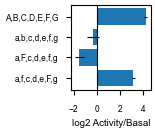

In [10]:
# Add in the WT strong enhancers as reference
inactive_swaps = pd.concat([
    inactive_swaps,
    swap_coords[swap_coords["label"] == strong_enhancer_id + "_WT"]
])

# Join with activity measurements, only keep the first instance of the SE
swaps_activity = activity_df.set_index("label").join(
    inactive_swaps.set_index("label").drop(columns="original_seq"),
    how="inner",
)
swaps_activity = swaps_activity[~swaps_activity.index.duplicated(keep="first")]
swaps_activity = swaps_activity.reset_index().set_index("blocks")

# swaps_activity = swaps_activity.loc[sort_blocks(swaps_activity.index.to_list())]
swaps_activity = swaps_activity.loc[[
    # WT strong enhancer
    "A,B,C,D,E,F,G",
    # WT inactive
    "a,b,c,d,e,f,g",
    # Spacer swaps
    # "A,b,c,d,e,f,g",
    # "a,b,C,d,e,f,g",
    # "a,b,c,d,E,f,g",
    # "a,b,c,d,e,f,G",
    # Motifs
    # "a,b,c,D,e,f,g",
    "a,F,c,d,e,f,g",
    # "a,F,c,D,e,f,g",
    # RORB rearranged
    "a,f,c,d,e,F,g",
    # "a,B,c,D,e,F,g",
]]

swaps_activity = swaps_activity.reset_index().set_index("label")[::-1]

fig, ax = plt.subplots(figsize=plot_utils.get_figsize(0.15, 3.5 * len(swaps_activity) / 13))
ax.barh(
    np.arange(len(swaps_activity)),
    swaps_activity["expression_log2"],
    xerr=swaps_activity["sigma"],
    tick_label=swaps_activity["blocks"]
)
ax.set_xlabel("log2 Activity/Basal")
ax.axvline(0, color="k")
#ax.set_xlim((-3.5242497053595088, 4.6484117618096645))
ax.set_xticks(np.arange(-2, 5, 2))
plot_utils.save_fig(fig, os.path.join(figures_dir, f"inactiveSwapsCombinedBarplot_pair_{i}"))

a,b,c,d,e,f,g
[]
a,F,c,d,e,f,g
['F']
a,f,c,d,e,F,g
['F']


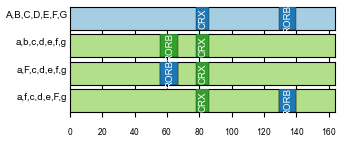

In [11]:
# We reverse the order so that the cartoons are drawn in the same order as the bars above
cartoon_swaps = swaps_activity[::-1]
nswaps = len(cartoon_swaps)
fig, ax_list = plt.subplots(
    nrows=nswaps,
    sharex=True,
    sharey=True,
    figsize=plot_utils.get_figsize(0.5, aspect=0.1*nswaps)
)
for ax, (idx, row) in zip(ax_list, cartoon_swaps.iterrows()):
    if row["blocks"].replace(",", "") == ordered_blocks.upper():
        plot_utils.visualize_sequence(
            row["sequence"],
            light_blue,
            ewms,
            mu,
            dark_blue,
            figax=(fig, ax),
        )
        ax.set_title(row["blocks"], x=-0.01, y=0.2, ha="right")
        continue

    plot_utils.visualize_sequence(
        row["sequence"],
        light_green,
        ewms,
        mu,
        dark_green,
        figax=(fig, ax),
    )
    ax.set_title(row["blocks"], x=-0.01, y=0.2, ha="right")
    # If a spacer was swapped, draw a light blue box, if a motif was swapped, draw a dark blue box
    print(row["blocks"])
    match = re.findall("[A-Z]", row["blocks"])
    print(match)
    if match:
        for x in match:
            block = x
            begin, end = block_coords[block]
            ## If a spacer was swapped
            if assign_block_type(strong_site_map, block_coords[block]) == "block":
                ax.axvspan(begin, end, facecolor=light_blue, edgecolor="black", zorder=3)
            else:
            ## If a motif was swapped
                initial_block = ordered_blocks[row["blocks"].replace(",", "").find(x)].upper()
                begin, end = block_coords[initial_block]                
                ax.axvspan(begin, end, facecolor=dark_blue, edgecolor="black", zorder=3)
                ax.text(np.mean((begin, end)), np.mean(ax.get_ylim()), SE_TFs[x], ha="center", va="center", color="white", rotation=90)
    
    ax.set_yticks([])
    
plot_utils.save_fig(fig, os.path.join(figures_dir, f"inactiveSwapsCartoons_pair_{i}"))

In [12]:
white = (1., 1., 1.)
slide_coords_new = slide_coords[
    (slide_coords["original_seq"] == strong_enhancer_id) 
]
slide_coords_new = slide_coords_new.set_index("label").drop(columns = ["original_seq"])
slide_activity_df = activity_df.set_index("label").join(
    slide_coords_new,
    how="inner"
)
slide_activity_df = slide_activity_df.sort_values(by="position_moved_to")

In [13]:
slide_activity_df["motif_name_and_original_position"].dropna().unique()

array(['RORB_129'], dtype=object)

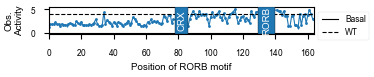

In [14]:
slide_groups = slide_activity_df["motif_name_and_original_position"].dropna().unique()

for x in slide_groups:
    data = slide_activity_df[slide_activity_df["motif_name_and_original_position"] == x]

    fig, ax = plt.subplots(figsize=plot_utils.get_figsize(0.5, aspect=0.1))
    ax.errorbar(
        data["position_moved_to"],
        data["expression_log2"],
        yerr=data["sigma"],
        zorder=1,
        fmt="o-",
        #color="k"
    )
    ax.axhline(0, color="k", label="Basal")
    ax.axhline(
        slide_activity_df.loc[strong_enhancer_id + "_WT", "expression_log2"].mean(),
        color="k",
        linestyle="--",
        label="WT"
    )
    fig, ax = plot_utils.visualize_sequence(
        strong_enhancer_wt_seq,
        white,
        ewms,
        mu,
        dark_blue,
        # (31/255, 120/255, 180/255, 50/100),
        figax=(fig, ax)
    )
    ax.set_ylabel("Obs.\nActivity")
    ax.set_xlabel(f"Position of {x.split('_')[0]} motif")
    # ax.set_xlabel(f"Position of {x} motif")
    ax.legend(loc="upper left", bbox_to_anchor=(1,1))
    plot_utils.save_fig(fig, os.path.join(figures_dir, f"strongEnhancerSlide_{x}_pair_{i}"))

In [15]:
slide_activity_nodup = slide_activity_df.drop_duplicates(subset="sequence")
slide_seqs = slide_activity_nodup["sequence"]
hypos = []
actuals = []
actuals_decoded = []
preds = []
for seq in slide_seqs:
    h, a, p = deeplift_utils.saliency_map(seq, model)
    hypos.append(np.expand_dims(h, axis=0))
    actuals.append(np.expand_dims(a, axis=0))
    actuals_decoded.append(
        deeplift_utils.actual_saliency_track(seq, model)
    )
    preds.append(p)
    
hypos = np.concatenate(hypos, axis=0)
actuals = np.concatenate(actuals, axis=0)
actuals_decoded = np.array(actuals_decoded)
preds = np.array(preds)

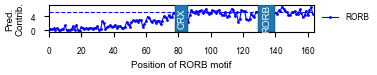

In [16]:
rorb_importance = {}
rorb_size = len(ewms["RORB"])

for j, variant in slide_activity_nodup.reset_index().iterrows():
    start_pos, fiveprime = variant[["position_moved_to", "is_moved_5prime"]]
    track = actuals_decoded[j]
    # If it is the WT position, store separately
    if fiveprime is np.nan:
        wt_rorb_importance = track[129:129+rorb_size].sum()
    else:
        start_pos = int(start_pos)
        # Find the RORB site
        if fiveprime:
            rorb_importance[start_pos] = track[start_pos:start_pos+rorb_size].sum()
        else:
            rorb_importance[start_pos] = track[start_pos-rorb_size:start_pos].sum()

rorb_importance = pd.Series(rorb_importance)

fig, ax = plt.subplots(figsize=plot_utils.get_figsize(0.5, aspect=0.1))
ax.plot(
    rorb_importance.index,
    rorb_importance,
    marker="o",
    color="blue",
    label="RORB"
)
ax.axhline(
    wt_rorb_importance,
    color="blue",
    linestyle="--",
)
plot_utils.visualize_sequence(
    strong_enhancer_wt_seq,
    white,
    ewms,
    mu,
    dark_blue,
    figax=(fig, ax)
)
ax.set_yticks([0, 4])
ax.set_xlabel("Position of RORB motif")
ax.set_ylabel("Pred.\nContrib.")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
plot_utils.save_fig(fig, os.path.join(figures_dir, f"strongEnhancerSlideImportance_{x}_Pair_{i}"))